##### Init dataset

In [53]:

import numpy as np
import torch
from bucketed_scene_flow_eval.datasets import construct_dataset

dataset ="Argoverse2CausalSceneFlow"
root_dir = "/mnt/personal/vacekpa2/data/argoverse2/sensor/val"
flow_dir = "/mnt/personal/vacekpa2/data/argoverse2/sensor/val_sceneflow_feather"
sequence_length = 10
# use modes from the Mode enum

dataset = construct_dataset(
    dataset,
    dict(
        root_dir=root_dir,
        with_rgb=True,
        flow_data_path=flow_dir,
        subsequence_length=sequence_length,
        use_gt_flow=False,
    ),
)

def unpack_one_frame(dataset, i):
    ''' 
    Unpacks one frame from the Argoverse SceneFlow dataset.
    
    Args:
        dataset (Dataset): The dataset containing the frames.
        i (int): The index of the frame to unpack.
        
    Returns:
        dict: A dictionary containing the unpacked frame data.
    '''
    
    data = dataset[i]

    # lidar1 = data[0]
    pc1 = data[0].lidar.as_tensor().detach().cpu().numpy()
    ground1 = data[0].is_ground.detach().cpu().numpy()

    # lidar2 = data[1]
    pc2 = data[1].lidar.as_tensor().detach().cpu().numpy()
    ground2 = data[1].is_ground.detach().cpu().numpy()

    uuid1 = data[0].sweep_uuid[0]
    uuid2 = data[1].sweep_uuid[0]
    timestamp = data[0].sweep_uuid[1]

    if uuid1 != uuid2: 
        print('uuid mismatched')

    relative_pose = data[2].matrix().detach().cpu().numpy()[0]	# batch

    pose1 = data[0].city_SE3_ego.matrix()   # compute it w.r.t ego position in first frame
    pose2 = data[1].city_SE3_ego.matrix()

    flow = data[3].flow.detach().cpu().numpy()
    flow_valid = data[3].is_valid.detach().cpu().numpy()
    category_indices = data[3].category_indices.detach().cpu().numpy()
    dynamic = data[3].is_dynamic.detach().cpu().numpy()
    class_names = data[0].cuboids.category

    d_dict = {'pc1' : pc1,
                'pc2' : pc2,
                'pose1' : pose1,
                'pose2' : pose2,
                'relative_pose' : relative_pose,            
                'ground1' : ground1,
                'ground2' : ground2,
                'flow' : flow,
                'flow_valid' : flow_valid,
                'dynamic' : dynamic,
                'category_indices' : category_indices,
                'uuid1' : uuid1,
                'uuid2' : uuid2,
                'class_names' : class_names
                
                }

    # transform to second point cloud, pose is relative pc1 -> pc2
    sync_pts = np.dot(relative_pose[:3, :3], pc1[:,:3].T).T + relative_pose[:3, 3]
    sync_pts = np.concatenate((sync_pts, pc1[:, 3:4]), axis=1)
    
    return d_dict

Loading /tmp/av2_raw_data_with_rgb_True_use_gt_flow_False_raw_data_path_[PosixPath('/mnt/personal/vacekpa2/data/argoverse2/sensor/val')]_flow_data_path_[PosixPath('/mnt/personal/vacekpa2/data/argoverse2/sensor/val_sceneflow_feather')]/causal_subsequence_10_lookup.pkl of size 216.85 KB


##### Preprocess Data

In [54]:
global_pc_list = []

frame_list = dataset[0] # frame, iterate

for idx in range(len(frame_list)):
    
    frame = frame_list[idx]
    sequence = frame.log_id # type: ignore
    ts = frame.log_timestamp # type: ignore

    pc_frame = frame.pc # type: ignore

    # global_pts = pc_frame.global_pc.points
    # global_pts = pc_frame.pc.transform(pc_frame.global_pose).points
    
    pc = pc_frame.global_pc.points
    
    pose = pc_frame.global_pose.transform_matrix
    
    global_pts = pc
    # global_pts = np.dot(pose[:3, :3], pc.T).T + pose[:3, 3]
    
    global_pts = np.insert(global_pts, 3, idx, axis=1)
    
    global_pc_list.append(global_pts)
        # add ground removal

global_pc = np.concatenate(global_pc_list, axis=0)



In [56]:
from vis.deprecated_vis import visualize_points3D

from av2.torch.data_loaders.scene_flow import SceneFlowDataloader
dataset_path = "/mnt/personal/vacekpa2/data/"
dataset = SceneFlowDataloader(dataset_path, "argoverse2", "val")


In [58]:
pc_list = []
pose_list = []

sync_pose_list = []
sync_pc_list = []

# TODO, split sequences
for i in range(1000,1010):
    data_dict = unpack_one_frame(dataset, i)
    
    # relative_pose = data_dict['relative_pose']
    pc1 = data_dict['pc1'][data_dict['ground1'] == 0] # TODO split functionality
    pc1 = np.insert(pc1, 3, i, axis=1)
    
    pc_list.append(pc1)
    pose_list.append(data_dict['pose1'])

for i in range(len(pose_list)):
    
    pc1 = pc_list[i]
    pose1 = pose_list[0][0]
    pose2 = pose_list[i][0]
    
    sync_pose = np.dot(np.linalg.inv(pose1), pose2)
    sync_pose_list.append(sync_pose)


    sync_pts = np.dot(sync_pose[:3, :3], pc1[:,:3].T).T + sync_pose[:3, 3]
    sync_pts = np.concatenate((sync_pts, pc1[:, 3:4]), axis=1)
    
    sync_pc_list.append(sync_pts)

visualize_multiple_pcls(*sync_pc_list)

In [5]:
from sklearn.cluster import DBSCAN

to_cluster_pc = np.concatenate(sync_pc_list, axis=0)    # no time so far
to_cluster_pc[:, 3] /= 10  
to_cluster_pc[:, 2] /= 2 
# # TODO scale time
# # TODO init flow with open3d icp?
# # cluster using open3d dbscan

init_ids = DBSCAN(eps=0.3, min_samples=1).fit_predict(to_cluster_pc)


# Motion Model

LieTorch implementation

In [59]:
from vis.deprecated_vis import *
idx = init_ids[557877]

# visualize_points3D(to_cluster_pc[:, :3][init_ids==idx], to_cluster_pc[:, 3][init_ids==idx])
# visualize_points3D(to_cluster_pc[:, :3], to_cluster_pc[:, 3])

pcds = to_cluster_pc[:][init_ids==idx]
# Method
# 1) build map from one frame
# 2) ICP to align of instances to the reconstructed map
# 3) Downsample map
# 4) Transfer instances to other frames based on overlaps
# 5) repeat 2-4
# opt) Freespace as place in the map and it deletes the map points?


# Trajectory really seems to be good only for init
# KISS-ICP wont probably work, as the easy cluster is still noise and do not use all times at once
obj_pts_list = []
for i, t in enumerate(np.unique(pcds[:,3])):

#     pcd = o3d.geometry.PointCloud()
    obj_pts_list.append(pcds[pcds[:, 3] == t][:,:3])


# visualize_points3D(to_cluster_pc[:,:3], init_ids)

visualize_multiple_pcls(*obj_pts_list)
visualize_points3D(to_cluster_pc[:,:3], init_ids)

In [41]:
# KISS-ICP
# visualize_multiple_pcls(*obj_pts_list)
# store obj_pts_list as pcd points
# no gpu?
import numpy as np
import open3d as o3d

pts_list = []
orig_mean_list = []

# spatio-temporal pc
# visualize_multiple_pcls(*obj_pts_list)
for i in range(len(obj_pts_list)):
    
    obj_mean = obj_pts_list[i].mean(axis=0) 
    pts = obj_pts_list[i] - obj_mean #.var(axis=0)  # Treat only dynamic this way

    
    pts_list.append(pts)
    orig_mean_list.append(obj_mean)

# shifted by own means
# visualize_multiple_pcls(*pts_list)
trans_list = []

reference_frame = 0 # len(obj_pts_list) - 1

for t in range(0, len(obj_pts_list)):
    if t == reference_frame: 
        trans_list.append(np.eye(4))
        continue
    
    # if t != 4: continue 

    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(pts_list[t])
    # source.estimate_normals(
    # search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn))

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(pts_list[reference_frame])   # compute to
    # target.estimate_normals(
    # search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=max_nn))
    
    threshold = 1.0 # should be same parameter as spatio-temporal clustering?
    trans_init = np.eye(4)  # reinit?
    
    icp_reg = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,
                                                        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                                                        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
    
    trans_list.append(icp_reg.transformation)
    # print(icp_reg, icp_reg.transformation)


# vis
global_list = [(trans_list[t][:3,:3] @ pts_list[t].T).T + trans_list[t][:3,-1] for t in range(len(trans_list))]

# reinited transforms
from scipy.signal import savgol_filter
# print(trans_list)
x = np.array([i[:3, -1] for i in trans_list], dtype=np.float64)
smoothed_x = savgol_filter(x, 3, 1, axis=0)

# global_list.insert(0, smoothed_x)


reconstructed_poses = x + np.array(orig_mean_list)
smoothed_x = savgol_filter(reconstructed_poses, 4, 2, axis=0)

# try to use smoothed path as initial guess

# visualize_multiple_pcls(*global_list)



In [28]:
visualize_multiple_pcls(*global_list)
# visualize_multiple_pcls(*[global_list[i] + smoothed_x[i] - reconstructed_poses[i] for i in range(len(global_list))])
# visualize_multiple_pcls(*[reconstructed_poses, smoothed_x])

In [50]:
# Downsample in open3d
stacked_obj = np.concatenate(global_list, axis=0)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(stacked_obj)
pcd = pcd.voxel_down_sample(voxel_size=0.2)

# print(reconstructed_poses)
# visualize_multiple_pcls(*[np.array(pcd.points)] + obj_pts_list)
# visualize_multiple_pcls(*[np.concatenate(obj_pts_list), reconstructed_poses])

# unroll with reconstructed poses
shape_along_time = [np.asarray(pcd.points) + reconstructed_poses[i] for i in range(len(reconstructed_poses))]

visualize_multiple_pcls(*[np.concatenate(shape_along_time)] + obj_pts_list)
# visualize_multiple_pcls(*[np.concatenate(obj_pts_list), smoothed_x])
# visualize_points3D(np.array(pcd.points), np.ones(len(pcd.points)))

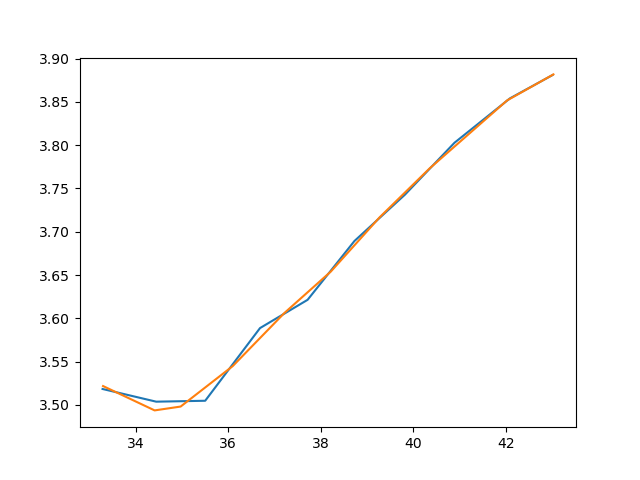

In [9]:

from vis.deprecated_vis import imshow
plt.close()

plt.plot(reconstructed_poses[:,0], reconstructed_poses[:,1], label='orig')
plt.plot(smoothed_x[:,0], smoothed_x[:,1], label='smoothed')

imshow(plt)

##### Lie Algebra

In [ ]:
import torch
from lietorch import SO3
from itertools import chain

idx = 86 # 18
obj_pts = pc1.view(-1,3)[clusters == idx]
obj_pts_list = [pc1[t][clusters.reshape(len(pc1), -1)[t] == idx] for t in range(len(pc1))]
time_means = torch.stack([pc1[t][clusters.reshape(len(pc1), -1)[t] == idx].mean(dim=0) for t in range(len(pc1))])

time_means[..., 2] = time_means[..., 2].median()    # can be initialized more intelligently

# yaw_angle = torch.atan2(flow[:,:,0], flow[:,:,1] + 1e-6) # T x N    
    
# point_displacements = time_means.diff(dim=0)
# yaws = torch.atan2(point_displacements[..., 0], point_displacements[..., 1] + 1e-6) # smooth yaws


# rot_vectors = torch.zeros(len(time_means), 3, device=pc1.device)
# rot_vectors[:-1, 2] = yaws
# rot_vectors[-1, 2] = rot_vectors[-2, 2] # reassign last as the previous
# rot_vectors.requires_grad_(True)

target_mean = time_means[-1]
# shift_to_target = target_mean - time_means

for i in range(len(obj_pts_list)):
    # obj_pts_list[i] = obj_pts_list[i] - obj_pts_list[i].mean(axis=0)
    # geometrical mean
    geometrical_middle = obj_pts_list[i].max(0)[0] - obj_pts_list[i].min(0)[0]
    obj_pts_list[i] = obj_pts_list[i] - geometrical_middle
    

# translation = time_means + shift_to_target
translation = torch.zeros((len(pc1), 3), device=pc1.device)
translation.requires_grad_(True)

# 1) posunu vsechno do stredu jako init ---> hodila by se inicializace ze sceneflow?
# 2) optimalizuju hledani stredu tak, aby body sedeli na sobe a zaroven by byl stred ve stejnem miste (shape reconstruct)

yaws = torch.zeros((len(time_means), 1), device=pc1.device, requires_grad=True)

icp_optimizer = torch.optim.Adam(chain([translation, yaws]), lr=0.1)

max_iters = 2
# with torch.autograd.set_detect_anomaly(True):
for it in tqdm(range(max_iters)):
    
    rot_vectors = torch.cat((torch.zeros((len(time_means), 2), device=yaws.device), yaws), dim=1)      # constrained icp
    
    R = SO3.exp(rot_vectors)
    R_mat = R.matrix()
    
    loss = 0
    transformed_pts = []

    for t in range(len(pc1) - 1, -1, -1):
        # do not forget to shift to center
        
        pts = obj_pts_list[t] 
        out = (R_mat[t][:3,:3] @ (pts - translation[t]).T).T + translation[t]  # not checked! add translation etc.
        
        dist, _, _ = knn_points(out.unsqueeze(0), obj_pts_list[-1].unsqueeze(0), K=1)

        per_point_dist = dist[0,:,0]
        loss += per_point_dist[per_point_dist < 0.3].mean()    # max correspondence limit
        
        # TODO - initialize with trajectory, diff2, shift directly to center of last pt? global pts
        # TODO - init target as the most dense point cloud? Shape registration ordering; https://arxiv.org/pdf/2210.08061.pdf
        # lots of things still missing
        # grid registration?
        # similar angles
        # if it < 300:    # for init
        loss += 0.5 * rot_vectors[:-1].diff(dim=0).norm(dim=-1).mean()
            # acceleration - not checked!
        loss += (translation[:-1] - translation[:-1].mean(dim=0)).norm(dim=0).mean() #.diff(dim=0).diff(dim=0).norm(dim=-1).mean()
        # loss += translation[:-1].diff(dim=0).diff(dim=0).norm(dim=0).mean()

        if it == max_iters - 1:
            transformed_pts.append(out.detach().cpu().numpy())
        # print(dist.shape)
    # print(loss.item())
    loss.mean().backward()
    
    icp_optimizer.step()
    icp_optimizer.zero_grad()


transformed_pts.append(translation)
# print(translation)
# visualize_points3D(vis_pc, vis_pc[:,2])
# visualize_multiple_pcls(*transformed_pts)
# visualize_multiple_pcls(*obj_pts_list)



# # pc1[0][clusters.reshape(len(pc1), -1)[0] == idx]
# visualize_multiple_pcls(*[obj_pts, time_means])

# obj1 = pc1[0][clusters.reshape(len(pc1), -1)[0] == idx]
# obj1_next = pc1[1][clusters.reshape(len(pc1), -1)[1] == idx]
# obj2 = pc1[4][clusters.reshape(len(pc1), -1)[4] == idx]


# obj_flow_scaled = fit_soft_rigidity_prior(obj1[None], obj1[None], pc2=obj2[None], max_iters=200)
# nsfp_pp_flow = fit_soft_rigidity_prior(obj1[None], obj1[None], pc2=obj1_next[None], max_iters=200)
# visualize_flow3d(obj1, obj2, obj_flow_scaled[0])
# visualize_flow3d(obj1, obj1_next, nsfp_pp_flow[0])
# visualize_flow3d(obj1, obj1_next, obj_flow_scaled[0] / (4-0))
